# FACE RECOGNITION WITH PCA

## Import necessary libraries

In [1]:
import numpy as np
import scann
import matplotlib.pyplot as plt
from skimage import io, transform, color
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_olivetti_faces

## Obtain the dataset

In [2]:
faces = fetch_olivetti_faces()
targets, data = faces["target"], faces["data"]

## Split dataset into train and test

In [3]:
x_train, x_test, y_train, y_test = train_test_split(
    data, 
    targets, 
    stratify = targets,
    test_size = 0.2,
    random_state = 0
)

([], [])

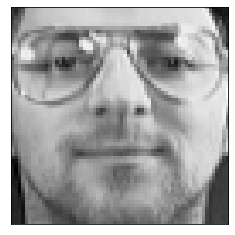

In [8]:
plt.imshow(x_train[37, :].reshape(64, 64), cmap = "gray")
plt.xticks([])
plt.yticks([])

## Explore original images

In [ ]:
def show_orignal_images(pixels):
    fig, axes = plt.subplots(6, 10, figsize=(11, 7), subplot_kw={'xticks':[], 'yticks':[]})
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.array(pixels)[i].reshape(64, 64), cmap='gray')
    plt.show()

In [ ]:
show_orignal_images(x_train)

## Preprocess datasets

In [ ]:
pca = PCA(n_components = 0.95)
pca.fit(x_train)

## Explore variance trend

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

## Explore Eigenfaces

In [ ]:
def show_eigenfaces(pca):
    fig, axes = plt.subplots(3, 8, figsize=(9, 4), subplot_kw={'xticks':[], 'yticks':[]})
    for i, ax in enumerate(axes.flat):
        ax.imshow(pca.components_[i].reshape(64, 64), cmap='gray')
        ax.set_title("PC " + str(i+1))
    plt.show()

In [ ]:
show_eigenfaces(pca)

## Transform data

In [ ]:
x_train = pca.transform(x_train);
x_test = pca.transform(x_test);

## Classifying as recognized and not-recognized by clustering

In [ ]:
def GetNeighbors(x_train, y_train, x_test, k):
    searcher = scann.scann_ops_pybind.builder(
        x_train, 
        k, 
        "dot_product"
    ).tree(
        num_leaves = 10, 
        num_leaves_to_search = 300, 
        training_sample_size = 500
    ).score_ah(
        2, 
        anisotropic_quantization_threshold = 0.2
    ).reorder(30).build()
    
    neighbors, distances = searcher.search_batched(x_test)
    categories = np.array(y_train)
    
    neighbors = categories[neighbors]
    
    return neighbors, distances

In [ ]:
x_train = x_train/np.sqrt(np.sum(np.square(x_train), axis = 1, keepdims = True))
x_train

In [ ]:
x_test = x_test/np.sqrt(np.sum(np.square(x_test), axis = 1, keepdims = True))
x_test

In [ ]:
neighbors, distances = GetNeighbors(x_train, y_train, x_test, 3)

In [ ]:
neighbors

In [ ]:
distances

In [ ]:
img = io.imread("me.jpg")
img = transform.resize(img, (64, 64))
img = color.rgb2gray(img)

In [ ]:
io.imshow(img)

In [ ]:
test = pca.transform(img.reshape(1, -1))

In [ ]:
test = test/np.sqrt(np.sum(np.square(test), axis = 1, keepdims = True))
test

In [ ]:
n, d = GetNeighbors(x_train, y_train, test, 1)

In [ ]:
if np.squeeze(d) < 0.6:
    print("Not recognized")